[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/astroML/astroML-notebooks/main?filepath=chapter10/10.4.ipynb)

# Temporally localized signals

## Introduction
A case frequently encountered in practice is a stationary signal with an event localized in time.  
When the noise properties are understood, and the expected shape of the signal is known, a tool
of choice is full forward modeling. That is, here too the analysis includes model selection and
parameter estimation steps, and is often called a matched filter search.

In this notebook, we will discuss two simple parametric models: 
1. a burst signal
2. a chirp signal   

In both examples we assume Gaussian known errors. The generalization to nonparametric models and
more complex models can be relatively easily implemented by modifying the code developed for
these two examples.

## Import functions
We use functions from PyMC3. We will also use `FT_continuous`, `IFT_continuous`, and `wavelet_PSD` from `astroML.fourier` for wavelet PSD analysis.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc

from astroML.fourier import FT_continuous, IFT_continuous, wavelet_PSD

## Matched Filter Burst Search
Consider a model where the signal is stationary, $y(t) = b_0 + \epsilon$, and at some unknown time, T, it
suddenly increases, followed by a decay to the original level b0 over some unknown time period.
Let us describe such a burst by

$$y_b=(t|T,A,\theta)=A_{gB}(t-T|\theta)$$

where the function $gB$ describes the shape of the burst signal $(gB(t < 0) = 0)$. This function is
specified by a vector of parameters $\theta$ and can be analytic, tabulated in the form of a template,
or treated in a nonparametric form.   
Typically, MCMC methods are used to estimate model parameters.

### 1. set up a burst model example
Using equation $y_b=(t|T,A,\theta)=A_{gB}(t-T|\theta)$, we set up a burst model as an example to show the matched filter search.  
Here we consider a case with $gB(t|\alpha) = exp(-\alpha t)$. The burst data set is shown in the plot below.

Text(0, 0.5, '$h_{\\rm obs}$')

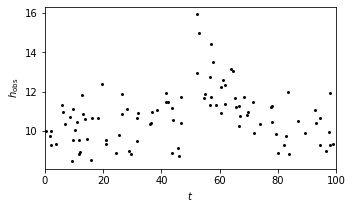

In [2]:
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)

# Show the model
fig = plt.figure(figsize=(9, 9))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

### 2. Set up and run the MCMC sampling
We use MCMC to compute the posterior parameters in the equation, in order to fit this burst model. The parameters we estimate using MCMC are $b_0$, $A$, $T$, and $\alpha$.  
This cell may take more than 2 minutes to run.

In [3]:
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        log_alpha = pm.Uniform('log_alpha', -10, 10)

        y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      sd=sigma, observed=y_obs)

        traces = pm.sample(draws=draws, tune=tune, return_inferencedata=False)

        return traces

# Use the summary() function to provide statistics for each variable
traces = compute_MCMC_results()
mean_vals = pm.summary(traces)['mean']
mean_vals['alpha'] = np.exp(mean_vals.pop('log_alpha'))

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_alpha, T, A, b0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 30 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8933143824958532, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9714992144629166, but should be close to 0.8. Try to increase the number of tuning steps.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9377623723516028, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/bsipocz/.pyenv/versi

### 3. Show estimated model
A matched filter search for a burst signal in time series data.  
* The top-right panel shows simulated data set generated from a model of the form $y(t) = b_0$ for $t < T$ and $y = b_0 + A exp[-a(t - T)]$ for $t > T$, with homoscedastic Gaussian errors with sigma = 2.  
* The posterior pdf for the four model parameters ($b_0$, $A$, $T$, and $\alpha$) is determined using MCMC and shown in the other panels.

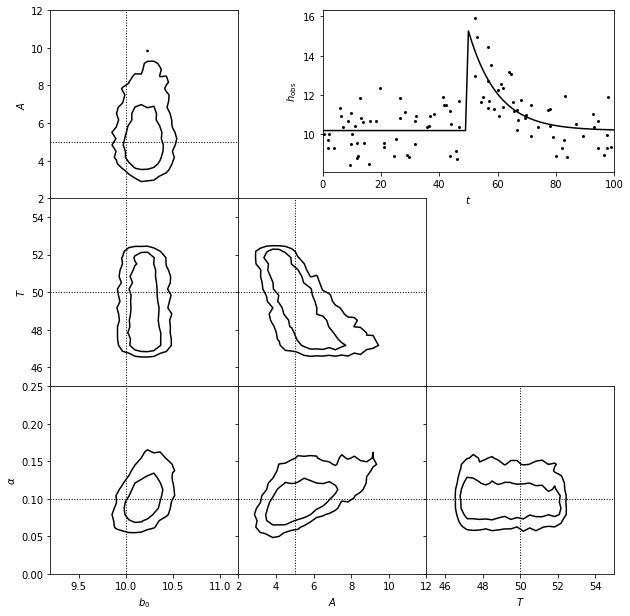

In [4]:
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [np.exp(traces['log_alpha'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

## Matched Filter Chirp Search
Here we consider a chirp signal, added to a stationary signal $b_0$,

$$y(t) = b_0 + Asin[\omega t + \beta t^2]$$

and analyze it using essentially the same code as for the burst signal.

### 1. set up a chirp model example
Using equation $y(t) = b_0 + Asin[\omega t + \beta t^2])$, we set up a chirp model as an example to show the matched filter search.  
The chirp data set is shown in the plot below.

Text(0, 0.5, '$h_{\\rm obs}$')

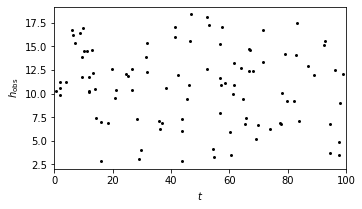

In [5]:
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

# show the model 
fig = plt.figure(figsize=(9, 9))
ax = plt.axes([0.5, 0.7, 0.45, 0.25])
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

### 2. Set up and run the MCMC sampling
We use MCMC to compute the posterior parameters in the equation, in order to fit this chirp model. The parameters we estimate using MCMC are $b_0$, $A$, $\omega$, and $\beta$.  

In [6]:
# Set up MCMC sampling
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50, testval=50 * np.random.random())
    A = pm.Uniform('A', 0, 50, testval=50 * np.random.random())
    log_beta = pm.Uniform('log_beta', -10, 10, testval=-4.6)
    log_omega = pm.Uniform('log_omega', -10, 10, testval=-2.3)

    y = pm.Normal('y', mu=chirp(t, b0, np.exp(log_beta), A, np.exp(log_omega)),
                  sd=sigma, observed=y_obs)

    # Choose the Metropolis-Hastings step rather than rely on the default
    step = pm.Metropolis()
    traces = pm.sample(draws=5000, tune=2000, step=step, return_inferencedata=False)
    
# Use the summary() function to provide statistics for each variable
mean_vals = pm.summary(traces)['mean']
mean_vals['omega'] = np.exp(mean_vals.pop('log_omega'))
mean_vals['beta'] = np.exp(mean_vals.pop('log_beta'))

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [log_omega]
>Metropolis: [log_beta]
>Metropolis: [A]
>Metropolis: [b0]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 13 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/bsipocz/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


### 3. Show estimated model
A matched filter search for a chirp signal in time series data.  
* The top-right panel shows a simulated data set generated from a model of the form $y = b_0+Asin[\omega t + \beta t^2]$, with homoscedastic Gaussian errors with sigma = 2.
* The posterior pdf for the four model parameters ($b_0$, $A$, $\omega$, and $\beta$) is determined using MCMC and shown in the other panels.  

Note that here the second term in the argument of the sine function above ($\beta t^2$) produces the
effect of increasing frequency in the signal seen in the top-right panel. The resulting fit shows a
strong inverse correlation between $\beta$ and $\omega$. This is expected because they both act to increase the
frequency: starting from a given model, slightly increasing one while slightly decreasing the other
leads to a very similar prediction.

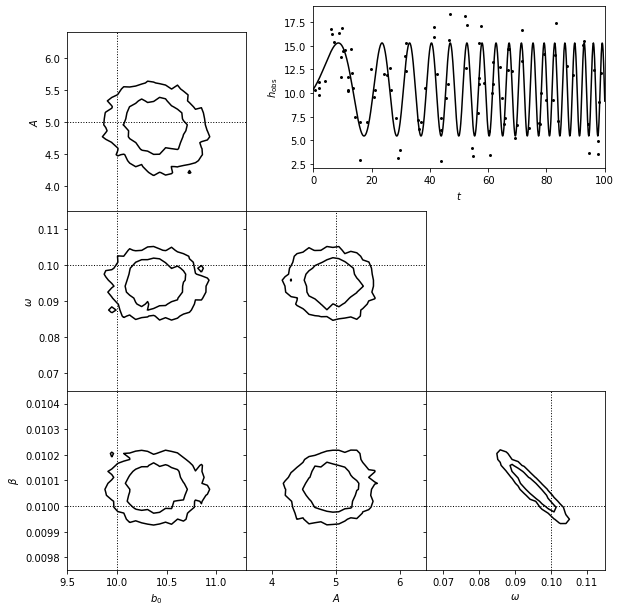

In [7]:
# Plot the model fit
fig = plt.figure(figsize=(9, 9))
ax = plt.axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, **mean_vals)

# Plot multiple panels with the traces
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

plot_mcmc([traces[ii] for ii in ['b0', 'A']]
          + [np.exp(traces['log_omega']), np.exp(traces['log_beta'])],
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

# Matched Filter Chirp Search
A more complex ten-parameter case of chirp modeling is show in this matched filter chirp search example. The chirp signal is
temporally localized and it decays exponentially for t > T:

$$y_C(t|T, A, \phi, \omega, \beta) = A sin[\phi + \omega(t - T) + \beta(t - T)^2] exp[-\alpha(t - T)]$$

### 1. set up a chirp model example
Using equation $y(t) = b_0 + Asin[\omega t + \beta t^2])$, we set up a chirp model as an example to show the matched filter search.  
The chirp data set is shown in the plot below. 

Text(0, 0.5, '$h_{\\rm obs}$')

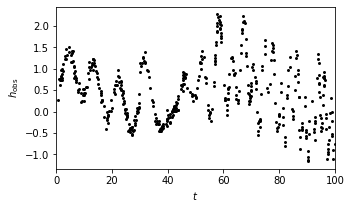

In [8]:
# Set up toy dataset
def chirp(t, T, A, phi, omega, beta):
    """chirp signal"""
    mask = (t >= T)
    signal = mask * (A * np.sin(phi + omega * (t - T) + beta * (t - T) ** 2))
    return signal


def background(t, b0, b1, omega1, omega2):
    """background signal"""
    return b0 + b1 * np.sin(omega1 * t) * np.sin(omega2 * t)


np.random.seed(0)
N = 500
T_true = 30
A_true = 0.8
phi_true = np.pi / 2
omega_true = 0.1
beta_true = 0.02
b0_true = 0.5
b1_true = 1.0
omega1_true = 0.3
omega2_true = 0.4
sigma = 0.1

t = 100 * np.random.random(N)

signal = chirp(t, T_true, A_true, phi_true, omega_true, beta_true)
bg = background(t, b0_true, b1_true, omega1_true, omega2_true)

y_true = signal + bg

y_obs = np.random.normal(y_true, sigma)

t_fit = np.linspace(0, 100, 1000)
y_fit = (chirp(t_fit, T_true, A_true, phi_true, omega_true, beta_true) +
         background(t_fit, b0_true, b1_true, omega1_true, omega2_true))

# show the model
fig = plt.figure(figsize=(9, 9))
ax = fig.add_axes([0.52, 0.7, 0.43, 0.25])
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

### 2. Set up and run the MCMC sampling
We use MCMC to compute the posterior parameters in the equation, in order to fit this chirp model. The parameters we estimate using MCMC are $T$, $A$, $\omega$, and $\beta$.  

In [9]:
# Set up and run MCMC sampling

with pm.Model():

    T = pm.Uniform('T', 0, 100, testval=T_true)
    A = pm.Uniform('A', 0, 100, testval=A_true)
    phi = pm.Uniform('phi', -np.pi, np.pi, testval=phi_true)

    b0 = pm.Uniform('b0', 0, 100, testval=b0_true)
    b1 = pm.Uniform('b1', 0, 100, testval=b1_true)

    log_omega1 = pm.Uniform('log_omega1', -3, 0, testval=np.log(omega1_true))
    log_omega2 = pm.Uniform('log_omega2', -3, 0, testval=np.log(omega2_true))

    omega = pm.Uniform('omega', 0.001, 1, testval=omega_true)
    beta = pm.Uniform('beta', 0.001, 1, testval=beta_true)

    y = pm.Normal('y', mu=(chirp(t, T, A, phi, omega, beta)
                           + background(t, b0, b1, np.exp(log_omega1), np.exp(log_omega2))),
                  tau=sigma ** -2, observed=y_obs)

    step = pm.Metropolis()

    traces = pm.sample(draws=5000, tune=2000, step=step, return_inferencedata=False)


labels = ['$T$', '$A$', r'$\omega$', r'$\beta$']
limits = [(29.75, 30.25), (0.75, 0.83), (0.085, 0.115), (0.0197, 0.0202)]
true = [T_true, A_true, omega_true, beta_true]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [omega]
>Metropolis: [log_omega2]
>Metropolis: [log_omega1]
>Metropolis: [b1]
>Metropolis: [b0]
>Metropolis: [phi]
>Metropolis: [A]
>Metropolis: [T]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### 3. Show estimated model
A matched filter search for a chirp signal in time series data.  
* The top-right panel shows a simulated data set generated from the chirp model.
* The posterior pdf for the four model parameters ($T$, $A$, $\omega$, and $\beta$) is determined using MCMC and shown in the other panels.  
* Seven of the parameters can be considered nuisance parameters, and we marginalize over them in the likelihood contours shown here.

Text(0, 0.5, '$h_{\\rm obs}$')

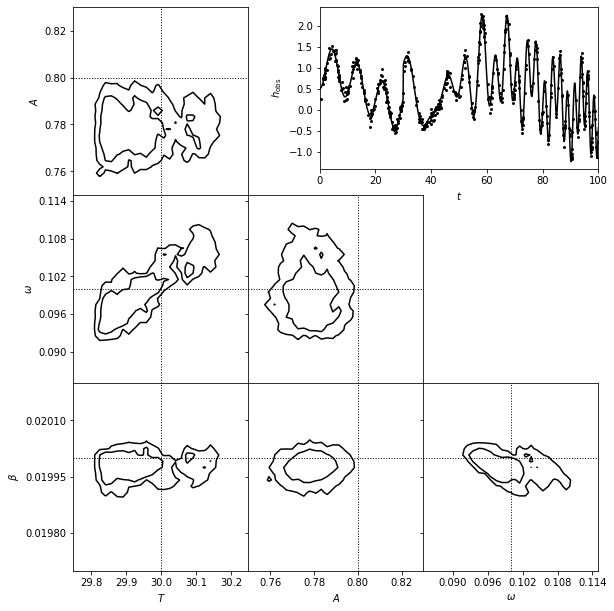

In [10]:
# Plot results
fig = plt.figure(figsize=(9, 9))

# This function plots multiple panels with the traces
axes_list = plot_mcmc([traces[i] for i in ['T', 'A', 'omega', 'beta']],
                      labels=labels, limits=limits,
                      true_values=true, fig=fig,
                      bins=30, colors='k',
                      bounds=[0.14, 0.08, 0.95, 0.95])

for ax in axes_list:
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(plt.MaxNLocator(5))

ax = fig.add_axes([0.52, 0.7, 0.43, 0.25])
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

## Chirp wavelet PSD
The signal in the absence of chirp is taken as

$$y(t) = b_0 + b_1 sin(\omega_1 t) sin(\omega_2 t)$$

Here, we can consider parameters $A$, $\omega$, $\beta$, and $\alpha$ as "interesting," and other parameters can
be treated as "nuisance."  
We will take the same chirp signal above and draw a wavelet PSD for demonstration.

### 1. compute the wavelet PSD of chirp model
We use the previous complex ten-parameter case of chirp modeling, and compute its wavelet PSD.

In [11]:
np.random.seed(42)
N = 4096
t = np.linspace(-50, 50, N)
h_true = chirp(t, -20, 0.8, 0, 0.2, 0.02)
h = h_true + np.random.normal(0, 1, N)

f0 = np.linspace(0.04, 0.6, 100)

# compute wavelet PSD
wPSD = wavelet_PSD(t, h, f0, Q=1.0)

### 2. plot signal and wavelet
Here, the signal with an amplitude of A = 0.8 is sampled in 4096 evenly spaced bins, and with Gaussian noise with sigma = 1. The two-dimensional wavelet PSD easily recovers the increase of characteristic chirp frequency with time.

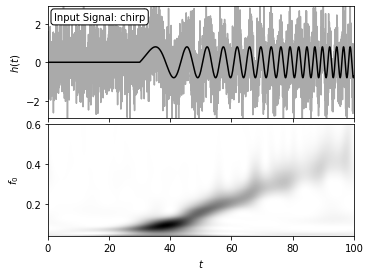

In [12]:
# Plot the  results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, left=0.1, right=0.95, bottom=0.1, top=0.95)

# Top: plot the data
ax = fig.add_subplot(211)
ax.plot(t + 50, h, '-', c='#AAAAAA')
ax.plot(t + 50, h_true, '-k')

ax.text(0.02, 0.95, "Input Signal: chirp",
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(boxstyle='round', fc='w', ec='k'))

ax.set_xlim(0, 100)
ax.set_ylim(-2.9, 2.9)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$h(t)$')

# Bottom: plot the 2D PSD
ax = fig.add_subplot(212)
ax.imshow(wPSD, origin='lower', aspect='auto',
          extent=[t[0] + 50, t[-1] + 50, f0[0], f0[-1]],
          cmap=plt.cm.binary)

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(0, 100)
ax.set_ylim(0.04, 0.6001)
ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

plt.show()